# Responsible and Explainable AI
TP2 - Images Data

*Erwan DAVID - Guillaume FAYNOT*

This notebook focuses on training a Convolutional Neural Network (CNN) to classify cancerous and non-cancerous image patches from the PatchCamelyon dataset. Additionally, we will explore explainability techniques such as Grad-CAM to interpret the model's predictions.

Data from PatchCameLyon Challenge can be found following [this link](https://github.com/basveeling/pcam).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import IterableDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import pandas as pd
import h5py
import copy
import pickle
import os
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

# Data Overview

The PatchCamelyon dataset contains image patches labeled as cancerous or non-cancerous. It consists of 327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections. Each image is annoted with a binary label indicating presence of metastatic tissue. There is no overlap in WSIs between the splits, and all splits have a 50/50 balance between positive and negative examples. PCam is intended to provide a new benchmark for machine learning models.

A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable the design of fully-convolutional models that do not use any zero-padding, to ensure consistent behavior when applied to a whole-slide image.

- We use only the training dataset, which contains sufficient data.
- The dataset is limited to 50,000 images and split into training, validation, and test sets:
  - **Training set**: 40,000 images
  - **Validation set**: 5,000 images
  - **Test set**: 5,000 images

In [2]:
df = pd.read_csv('camelyonpatch_level_2_split_train_meta.csv')

In [ ]:
def show(img, **kwargs):
  """
  general function to show torch/tensorflow tensor
  """
  img = np.array(img, dtype=np.float32)

  # check if channel first
  if img.shape[0] == 1:
    img = img[0]
  elif img.shape[0] == 3:
    img = np.moveaxis(img, 0, 2)
  # check if cmap
  if img.shape[-1] == 1:
    img = img[:,:,0]
  # normalize
  if img.max() > 1 or img.min() < 0:
    img -= img.min(); img/=img.max()

  plt.imshow(img, **kwargs)
  plt.axis('off')
  plt.grid(None)

def load_sample_images(h5_file):
  """
  Load the first five images from an h5 file.
  """
  images = []
  with h5py.File(h5_file, 'r') as h5_file:
    for i in range(5):
      img = h5_file['x'][i]
      gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
      images.append(gray_img)
    return h5_file['x'][:16]

def show_grid(images, df, cols, lines, **kwargs):
  plt.figure(figsize=(cols * 3, lines * 3))
  for i in range(cols * lines):
    plt.subplot(lines, cols, i+1)
    tumor = df['tumor_patch'][i]
    show(images[i], **kwargs)
    rect = patches.Rectangle((32, 32), 32, 32, linewidth=5,
                               edgecolor='red' if tumor else 'green', facecolor='none')
    plt.gca().add_patch(rect)
    if i == 0:
      red_patch = patches.Patch(color='red', label='Tumor tissue')
      green_patch = patches.Patch(color='green', label='No tumor tissue')
      plt.legend(handles=[red_patch, green_patch], loc='upper center', bbox_to_anchor=(0.5, 1.05), prop={'size': 14})
  plt.suptitle("Train images and labels", fontsize=20)
  plt.tight_layout()




We load the dataset metadata and visualize some sample images along with their labels. The labels indicate whether the image contains tumor tissue (red) or not (green). A helper function is used to display images in a grid format.

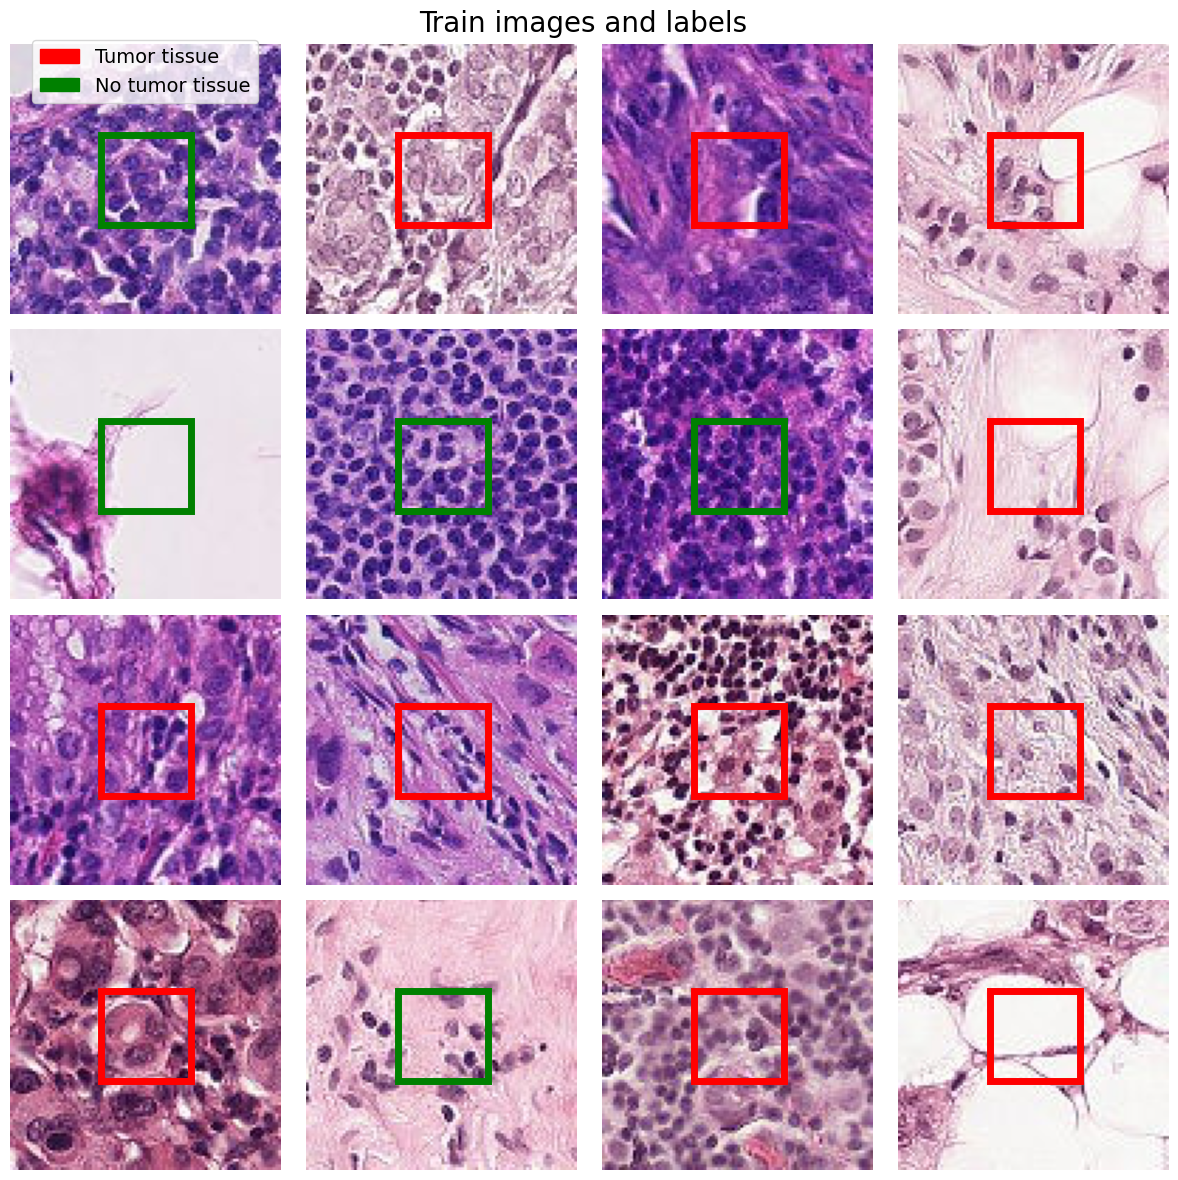

In [56]:
sample_x = load_sample_images('camelyonpatch_level_2_split_train_x.h5')
show_grid(sample_x[:16], df, 4, 4)

To optimize memory usage and training speed, the dataset is split into three subsets (train, validation, test) using stratified sampling to ensure balanced classes. The subsets are saved as HDF5 files for efficient loading during training.

In [ ]:
def split_and_save_hdf5(h5_path_img, h5_path_label, output_dir="./",
                        train_size=40000, val_size=5000, test_size=5000,
                        batch_size=2000):
    """
    Stratified split of a HDF5 file into three files (train/val/test) optimized for speed.
    """
    os.makedirs(output_dir, exist_ok=True)

    with h5py.File(h5_path_label, 'r') as f_y:
        labels = f_y['y'][:].reshape(-1)

    total_size = train_size + val_size + test_size
    all_indices = np.arange(len(labels))

    subset_indices, _ = train_test_split(
        all_indices,
        train_size=total_size,
        stratify=labels,
        random_state=42
    )

    subset_labels = labels[subset_indices]

    train_idx, temp_idx = train_test_split(
        subset_indices,
        train_size=train_size,
        stratify=subset_labels,
        random_state=42
    )
    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=test_size,
        stratify=labels[temp_idx],
        random_state=42
    )

    def save_subset(indices, name):
      out_path = os.path.join(output_dir, f"{name}.h5")
      num_samples = len(indices)

      with h5py.File(h5_path_img, 'r') as f_x, h5py.File(h5_path_label, 'r') as f_y, h5py.File(out_path, 'w') as f_out:
          x_out = f_out.create_dataset('x', shape=(num_samples, 96, 96, 3), dtype='uint8')
          y_out = f_out.create_dataset('y', shape=(num_samples,), dtype='int64')

          for i in tqdm(range(0, num_samples, batch_size), desc=f"Saving {name}"):
              batch = indices[i:i+batch_size]
              batch = np.array(batch) 
              sorted_order = np.argsort(batch)
              batch_sorted = batch[sorted_order]

              x_batch = f_x['x'][batch_sorted]  # No normalization
              y_batch = f_y['y'][batch_sorted].reshape(-1)

              original_order = np.argsort(sorted_order)
              x_out[i:i+len(batch)] = x_batch[original_order]
              y_out[i:i+len(batch)] = y_batch[original_order]

      print(f"Saved {name} set with {num_samples} samples at {out_path}")

    save_subset(train_idx, "train")
    save_subset(val_idx, "val")
    save_subset(test_idx, "test")


In [ ]:
split_and_save_hdf5('camelyonpatch_level_2_split_train_x.h5',
                          'camelyonpatch_level_2_split_train_y.h5')

Saving train: 100%|██████████| 20/20 [02:57<00:00,  8.87s/it]


Saved train set with 40000 samples at ./train.h5


Saving val: 100%|██████████| 3/3 [00:22<00:00,  7.34s/it]


Saved val set with 5000 samples at ./val.h5


Saving test: 100%|██████████| 3/3 [00:22<00:00,  7.38s/it]

Saved test set with 5000 samples at ./test.h5


# CNN Model

## Creating PyTorch DataLoaders
We define a custom PyTorch `IterableDataset` to load data directly from the HDF5 files. This approach avoids memory issues and ensures efficient data streaming during training and evaluation.

In [ ]:
def create_dataset(h5_path, batch_size=64, shuffle=False, num_workers=0):
    """
    Creates a PyTorch DataLoader from an HDF5 (.h5) file avoiding multiprocessing errors.
    """
    class HDF5IterableDataset(IterableDataset):
        def __init__(self, path, shuffle=False):
            super().__init__()
            self.path = path
            self.shuffle = shuffle

        def __iter__(self):
            with h5py.File(self.path, 'r') as f:
                x = f['x']
                y = f['y']
                indices = np.arange(len(x))
                if self.shuffle:
                    np.random.shuffle(indices)
                for i in indices:
                    img = x[i].astype('float32') / 255.0
                    img = torch.tensor(img).permute(2, 0, 1)  # HWC → CHW
                    label = torch.tensor(y[i].item(), dtype=torch.long)
                    yield img, label

    dataset = HDF5IterableDataset(h5_path, shuffle=shuffle)
    loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)
    return loader


In [6]:
train_ds = create_dataset("train.h5", batch_size=64, shuffle=True, num_workers=0)
valid_ds   = create_dataset("val.h5", batch_size=64, shuffle=False, num_workers=0)
test_ds  = create_dataset("test.h5", batch_size=64, shuffle=False, num_workers=0)

## CNN Model Architecture
The CNN model is designed to classify image patches as cancerous or non-cancerous. Key components include:
- **Convolutional layers**: Extract spatial features from the images.
- **Batch normalization**: Normalize activations to improve training stability.
- **Pooling layers**: Downsample feature maps to reduce dimensionality.
- **Fully connected layers**: Perform binary classification using the extracted features.
The model outputs a probability score using a sigmoid activation function.

The model is kept basic and simple to allow a better explainability

In [ ]:
class ClassCNN(nn.Module):
    def __init__(self):
        super(ClassCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # (N, 3, 96, 96) -> (N, 32, 96, 96)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # (N, 32, 96, 96) -> (N, 64, 96, 96)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)  # downsample -> (N, 64, 48, 48)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # -> (N, 128, 48, 48)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)  # -> (N, 128, 24, 24)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # -> (N, 256, 24, 24)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool3 = nn.AdaptiveAvgPool2d((6, 6))  # -> (N, 256, 6, 6)

        self.fc1 = nn.Linear(256 * 6 * 6, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))   # conv1
        x = F.relu(self.bn2(self.conv2(x)))   # conv2
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))   # conv3
        x = self.pool2(x)
        x = F.relu(self.bn4(self.conv4(x)))   # conv4
        x = self.pool3(x)

        self.feature_map = x  # store for Grad-CAM
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # binary classification
        return x


## Training the Model
The model is trained using the following setup:
- **Loss function**: Binary Cross-Entropy Loss (BCELoss) for binary classification.
- **Optimizer**: Adam optimizer with a learning rate of 0.001.
- **Early stopping**: Stops training if validation loss does not improve for 5 consecutive epochs.
Training and validation metrics (loss and accuracy) are logged and visualized after each epoch.

Using device: cuda

Epoch 1/8
Train Loss: 0.3961, Accuracy: 0.8300
Val   Loss: 0.3763, Accuracy: 0.8424

Epoch 2/8
Train Loss: 0.3400, Accuracy: 0.8550
Val   Loss: 0.3622, Accuracy: 0.8362

Epoch 3/8
Train Loss: 0.3138, Accuracy: 0.8700
Val   Loss: 0.3814, Accuracy: 0.8370

Epoch 4/8
Train Loss: 0.2905, Accuracy: 0.8808
Val   Loss: 0.5512, Accuracy: 0.7856

Epoch 5/8
Train Loss: 0.2643, Accuracy: 0.8918
Val   Loss: 0.8367, Accuracy: 0.6662

Epoch 6/8
Train Loss: 0.2445, Accuracy: 0.9015
Val   Loss: 0.2764, Accuracy: 0.8912

Epoch 7/8
Train Loss: 0.2261, Accuracy: 0.9103
Val   Loss: 0.2522, Accuracy: 0.9022

Epoch 8/8
Train Loss: 0.2089, Accuracy: 0.9173
Val   Loss: 0.2167, Accuracy: 0.9156


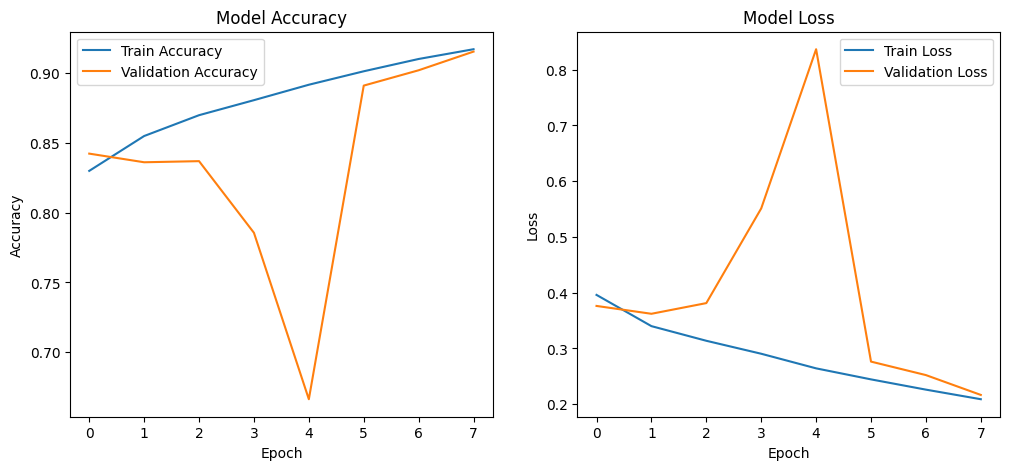

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = ClassCNN().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 8 # Let's do a first run with 8 epochs and see how it performs before increasing the number of epochs
patience = 5

# Callbacks
best_model_wts = copy.deepcopy(model.state_dict())
best_val_loss = float('inf')
epochs_no_improve = 0
train_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    model.train()
    train_loss, train_correct, num_train_samples = 0.0, 0, 0

    for inputs, labels in train_ds:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = inputs.size(0)
        num_train_samples += batch_size
        train_loss += loss.item() * batch_size
        preds = (outputs > 0.5).float()
        train_correct += (preds == labels).sum().item()

    train_loss /= num_train_samples
    train_acc = train_correct / num_train_samples

    model.eval()
    val_loss, val_correct, num_val_samples = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in valid_ds:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            batch_size = inputs.size(0)
            num_val_samples += batch_size
            val_loss += loss.item() * batch_size
            preds = (outputs > 0.5).float()
            val_correct += (preds == labels).sum().item()

    val_loss /= num_val_samples
    val_acc = val_correct / num_val_samples

    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

    train_history['loss'].append(train_loss)
    train_history['accuracy'].append(train_acc)
    train_history['val_loss'].append(val_loss)
    train_history['val_accuracy'].append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "class_model.pt")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_model_wts)

with open("class_training_history.pkl", "wb") as f:
    pickle.dump(train_history, f)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_history['accuracy'], label='Train Accuracy')
plt.plot(train_history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_history['loss'], label='Train Loss')
plt.plot(train_history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Results seem satisfying bit it's worth trying to perform more epochs (ie. 5 more) since there's no sign of overfitting

In [10]:
# Load the saved model weights
model.load_state_dict(torch.load("class_model.pt"))

# Continue training for a few more epochs
additional_epochs = 5
for epoch in range(epochs, epochs + additional_epochs):
    print(f"\nEpoch {epoch+1}/{epochs + additional_epochs}")
    model.train()
    train_loss, train_correct, num_train_samples = 0.0, 0, 0

    for inputs, labels in train_ds:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = inputs.size(0)
        num_train_samples += batch_size
        train_loss += loss.item() * batch_size
        preds = (outputs > 0.5).float()
        train_correct += (preds == labels).sum().item()

    train_loss /= num_train_samples
    train_acc = train_correct / num_train_samples

    model.eval()
    val_loss, val_correct, num_val_samples = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in valid_ds:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            batch_size = inputs.size(0)
            num_val_samples += batch_size
            val_loss += loss.item() * batch_size
            preds = (outputs > 0.5).float()
            val_correct += (preds == labels).sum().item()

    val_loss /= num_val_samples
    val_acc = val_correct / num_val_samples

    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

    train_history['loss'].append(train_loss)
    train_history['accuracy'].append(train_acc)
    train_history['val_loss'].append(val_loss)
    train_history['val_accuracy'].append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "class_model.pt")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_model_wts)

# Save the updated training history
with open("class_training_history.pkl", "wb") as f:
    pickle.dump(train_history, f)

C:\Users\guill\AppData\Local\Temp\ipykernel_30632\3647181147.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("class_model.pt"))



Epoch 9/13
Train Loss: 0.1919, Accuracy: 0.9266
Val   Loss: 0.1833, Accuracy: 0.9340

Epoch 10/13
Train Loss: 0.1746, Accuracy: 0.9315
Val   Loss: 0.2745, Accuracy: 0.9034

Epoch 11/13
Train Loss: 0.1655, Accuracy: 0.9376
Val   Loss: 0.1932, Accuracy: 0.9282

Epoch 12/13
Train Loss: 0.1516, Accuracy: 0.9423
Val   Loss: 1.0676, Accuracy: 0.8130

Epoch 13/13
Train Loss: 0.1432, Accuracy: 0.9451
Val   Loss: 0.2012, Accuracy: 0.9334


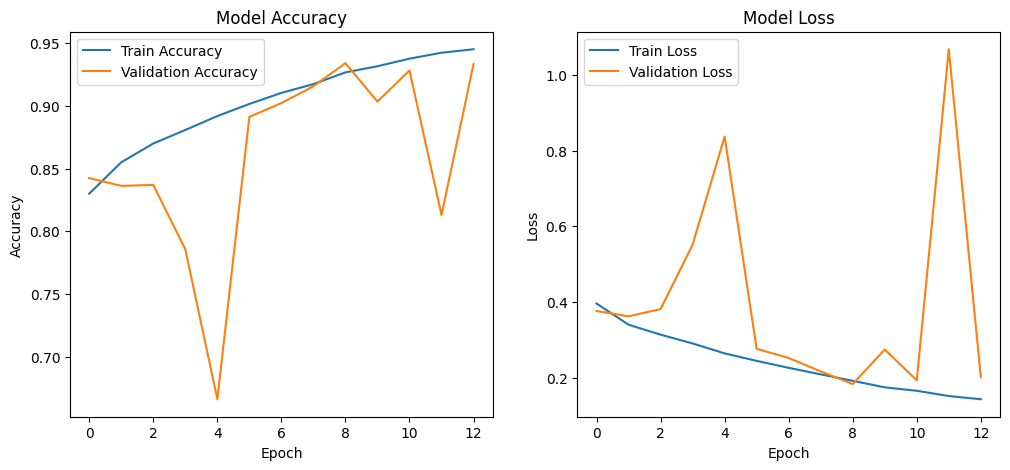

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_history['accuracy'], label='Train Accuracy')
plt.plot(train_history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_history['loss'], label='Train Loss')
plt.plot(train_history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

The validation loss fluctuates, but the accuracy continues to improve. For the purpose of this exercise, we keep 12 epochs, as the achieved accuracy (92%) is sufficient for explainability objectives.

## Evaluating the Model
The trained model is evaluated on the test set. Metrics include:
- **Confusion matrix**: Visualizes the model's performance in distinguishing cancerous and non-cancerous patches.
- **Accuracy**: Measures the overall classification performance.
- **Classification report**: Provides precision, recall, and F1-score for each class.

In [ ]:
# Loading the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ClassCNN()
model.load_state_dict(torch.load("class_model.pt", map_location=device))
model.eval()
model.to(device)


C:\Users\guill\AppData\Local\Temp\ipykernel_30632\1916664946.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("class_model.pt", map_locat

ClassCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): AdaptiveAvgPool2d(output_size=(6, 6))
  (fc1): Linear(in_features=9216, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_fe

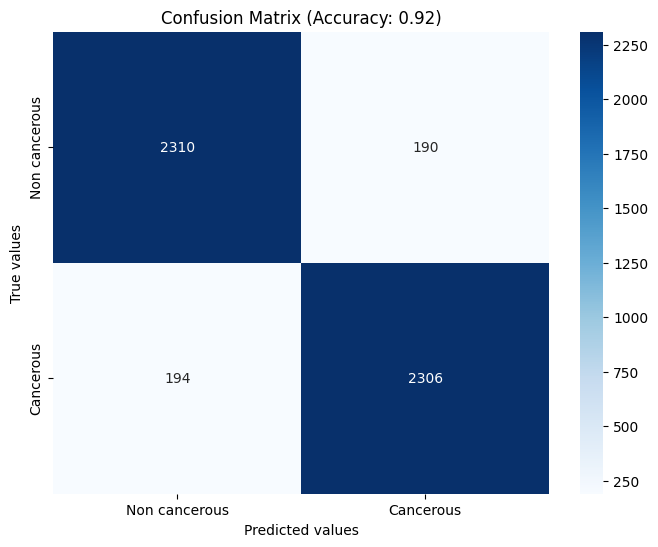


Classification Report :
               precision    recall  f1-score   support

Non cancerous       0.92      0.92      0.92      2500
    Cancerous       0.92      0.92      0.92      2500

     accuracy                           0.92      5000
    macro avg       0.92      0.92      0.92      5000
 weighted avg       0.92      0.92      0.92      5000



In [57]:
def evaluate_and_plot_confusion_matrix(model, test_ds):
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_ds:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu()
            preds = (outputs > 0.5).int().flatten()
            y_pred.extend(preds.tolist())
            y_true.extend(labels.int().tolist())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non cancerous', 'Cancerous'],
                yticklabels=['Non cancerous', 'Cancerous'])
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title(f'Confusion Matrix (Accuracy: {acc:.2f})')
    plt.show()

    print("\nClassification Report :")
    print(classification_report(y_true, y_pred, target_names=["Non cancerous", "Cancerous"]))

evaluate_and_plot_confusion_matrix(model, test_ds)

The model's accuracy is satisfactory, achieving a validation accuracy of 92%. This indicates that the model performs well in distinguishing between cancerous and non-cancerous patches. The high accuracy suggests that the model has effectively learned the underlying patterns in the dataset without significant overfitting.


# Explainability

## Explainability with Grad-CAM
Grad-CAM (Gradient-weighted Class Activation Mapping) is used to visualize the regions of the image that the model focuses on when making predictions. This helps in understanding the model's decision-making process. Heatmaps are overlaid on the original images to highlight important areas.

In [ ]:
def apply_gradcam(model, input_tensor, target_layer='conv4'):
    model.eval()
    input_tensor = input_tensor.to(device).unsqueeze(0)
    output = model(input_tensor)

    model.zero_grad()
    output.backward(torch.tensor([[1.0]]).to(device))  

    # Gradients on feature map
    gradients = model.feature_map.grad
    fmap = model.feature_map.detach().cpu().squeeze(0)

    # Hook pour récupérer le gradient
    grads = []

    def save_grad(module, grad_input, grad_output):
        grads.append(grad_output[0])

    hook = model.conv4.register_backward_hook(save_grad)
    output = model(input_tensor)
    model.zero_grad()
    output.backward(torch.tensor([[1.0]]).to(device))
    hook.remove()

    grad = grads[0].squeeze(0).detach().cpu()  # [C, H, W]

    weights = grad.mean(dim=(1, 2))  # [C]
    cam = torch.zeros(fmap.shape[1:], dtype=torch.float32)

    for i, w in enumerate(weights):
        cam += w * fmap[i, :, :]

    cam = np.maximum(cam, 0)
    cam = cam.numpy()
    cam = cv2.resize(cam, (96, 96))
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    return cam

C:\Users\guill\AppData\Local\Temp\ipykernel_30632\3269150396.py:15: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  gradients = model.feature_map.grad  # devrait être None ici : on va hook
c:\Program Files\Python312\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_fu

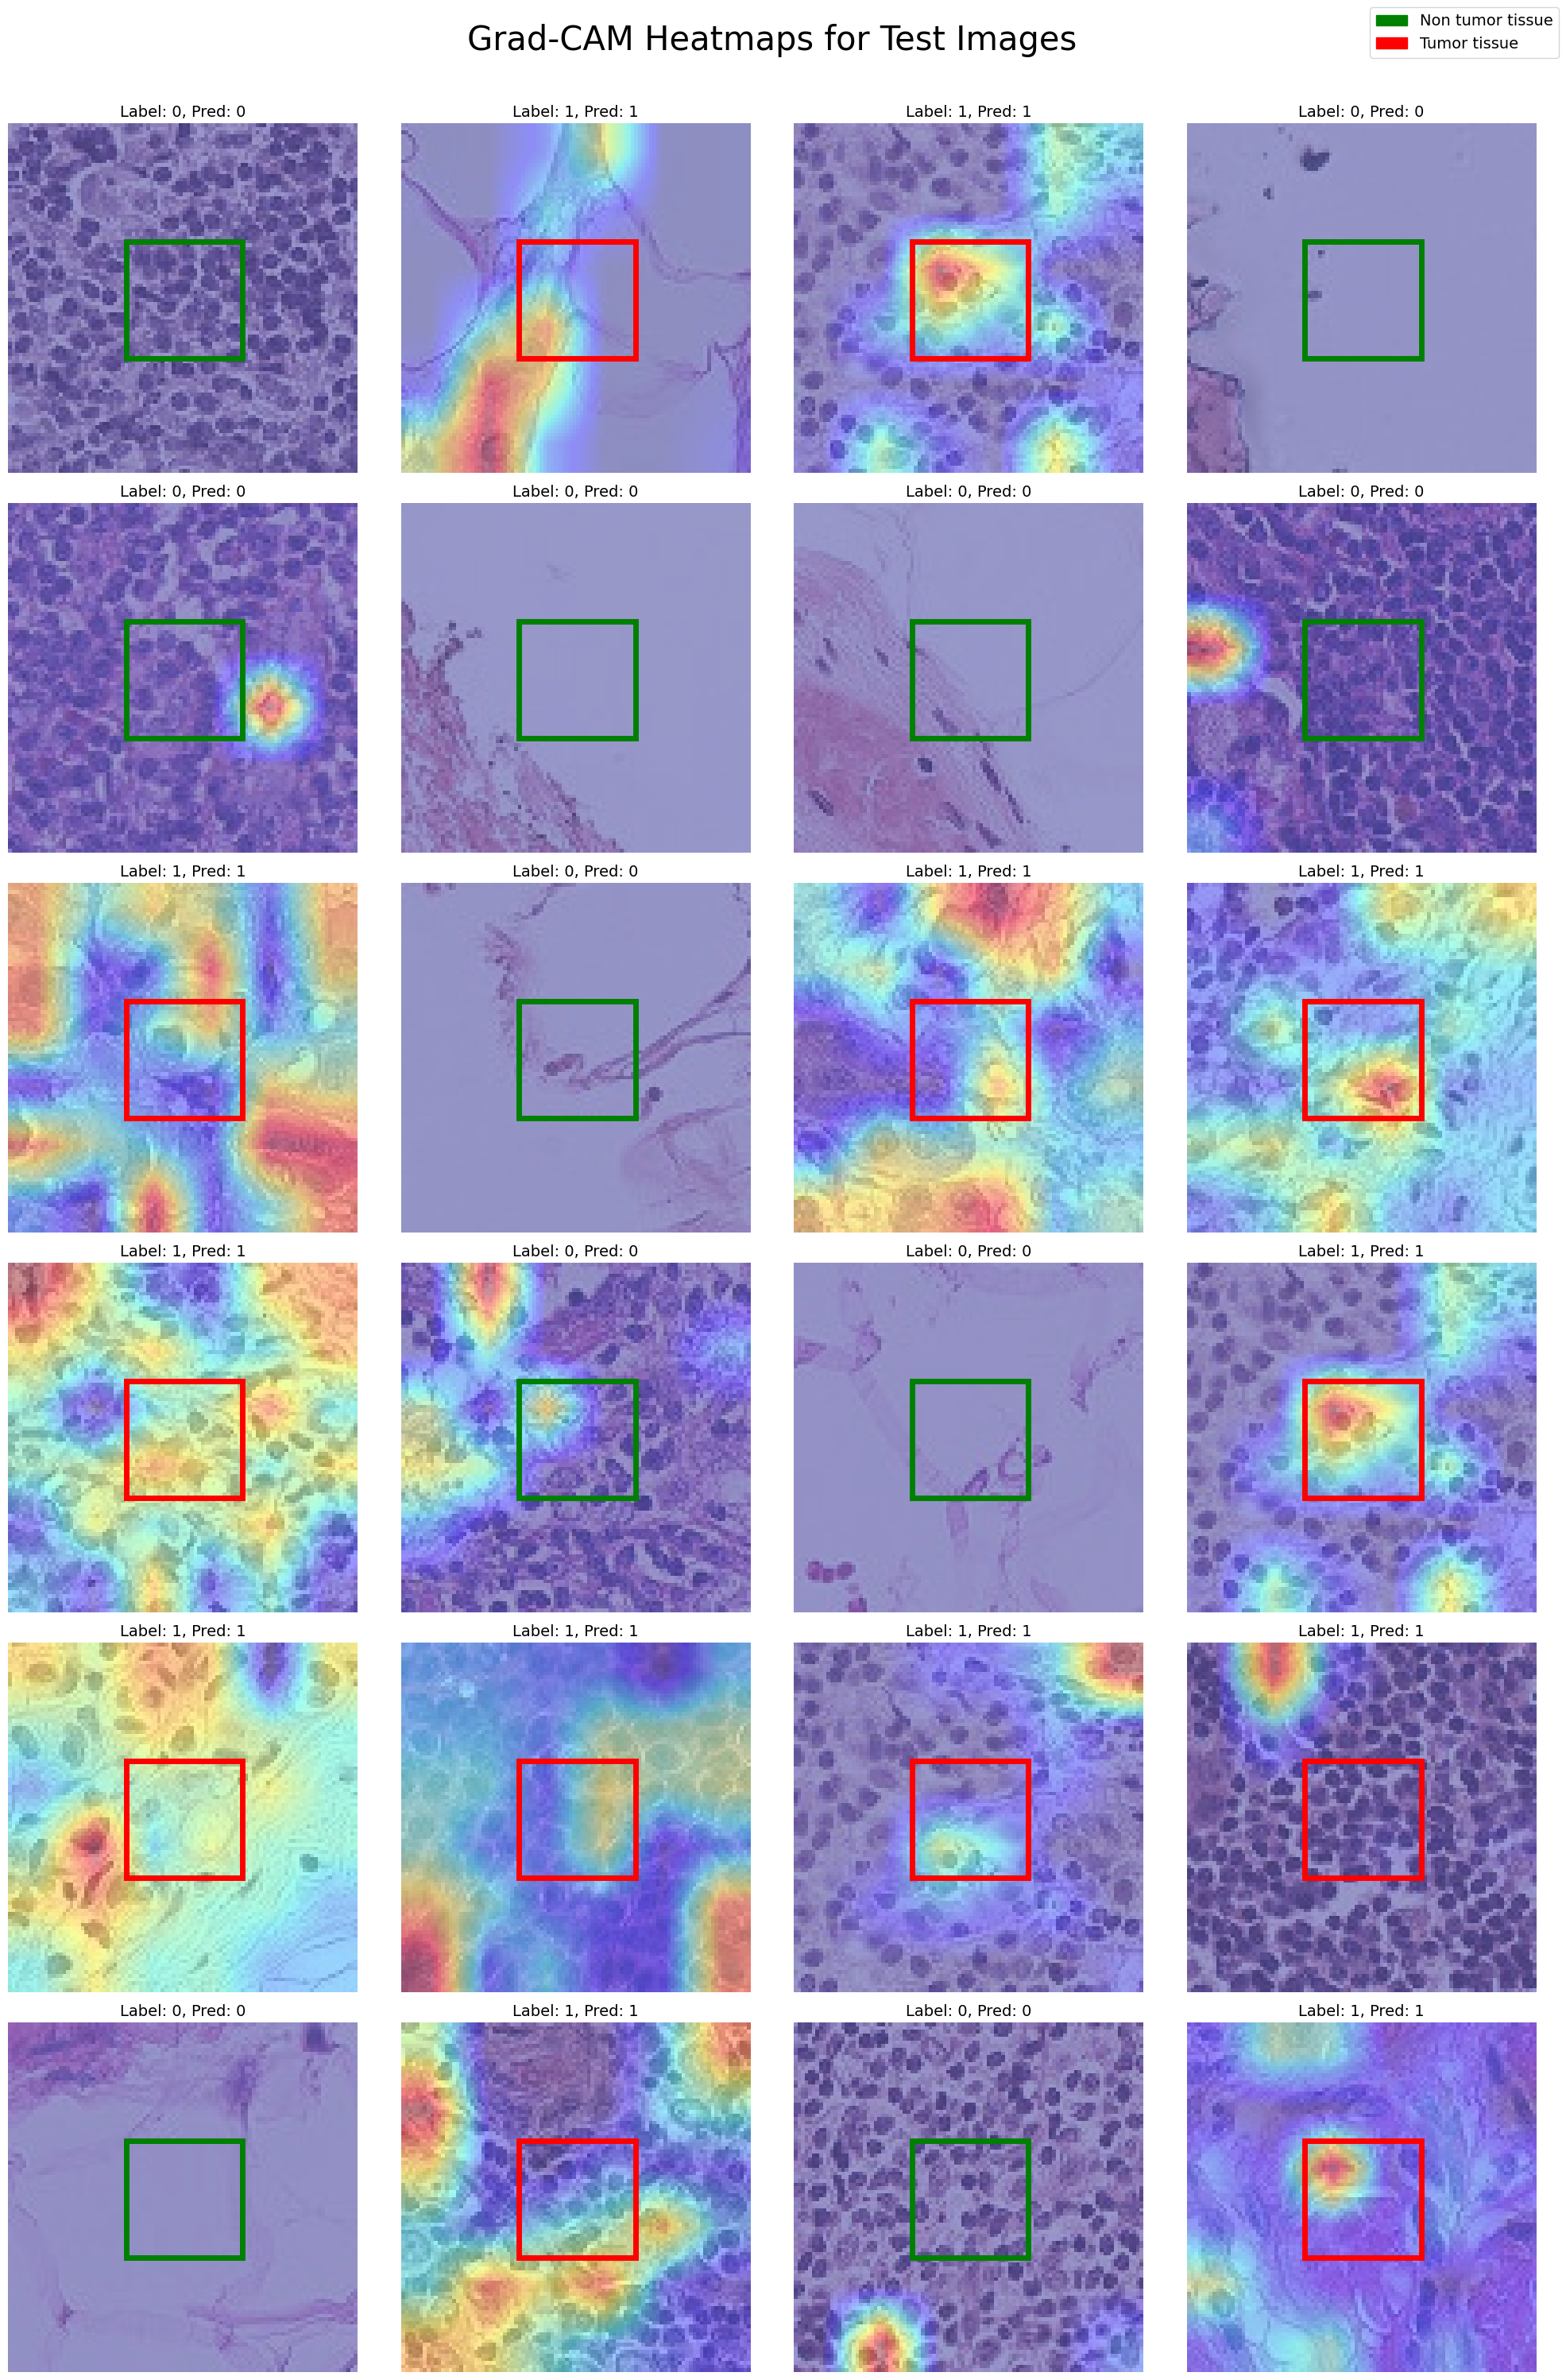

In [98]:
images_to_plot = 30
# Get the first images and labels from the test dataset
test_images, test_labels = next(iter(test_ds))
test_images = test_images[:images_to_plot].to(device)
test_labels = test_labels[:images_to_plot]

# Generate Grad-CAM heatmaps for the first 16 images
heatmaps = []
for i in range(images_to_plot):
    heatmap = apply_gradcam(model, test_images[i])
    heatmaps.append(heatmap)

# Plot the original images and their corresponding Grad-CAM heatmaps
fig, axes = plt.subplots(6, 4, figsize=(20, 30))

for idx, ax in enumerate(axes.flat):
    if idx >= images_to_plot:
        break
    # Original image
    img = test_images[idx].cpu().permute(1, 2, 0).numpy()
    ax.imshow(img, alpha=0.6)
    ax.imshow(heatmaps[idx], cmap='jet', alpha=0.4)
    ax.axis('off')
    # Draw a red square if the label is False, green otherwise
    color = 'green' if test_labels[idx].item() == 0 else 'red'
    rect = patches.Rectangle((32, 32), 32, 32, linewidth=5, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    # Predicted label
    predicted_label = (model(test_images[idx].unsqueeze(0)).item() > 0.5)
    ax.set_title(f"Label: {test_labels[idx].item()}, Pred: {int(predicted_label)}", fontsize=14)

# Add a title to the figure
fig.suptitle("Grad-CAM Heatmaps for Test Images", fontsize=30, y=0.99)

# Add a legend
legend_patches = [
    patches.Patch(color='green', label='Non tumor tissue'),
    patches.Patch(color='red', label='Tumor tissue')
]
fig.legend(handles=legend_patches, loc='upper right', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to fit title and legend
plt.show()

## Visualizing Grad-CAM Results
We generate Grad-CAM heatmaps for a subset of test images. The heatmaps are overlaid on the original images to show the regions that contributed most to the model's predictions. Tumor regions are highlighted in red, while non-tumor regions are highlighted in green.

We observe that the Grad-CAM heatmaps often highlight regions within the red square for images labeled as cancerous. This overlap indicates that the model focuses on the expected tumor regions when making predictions. While there are rare exceptions, the consistent alignment of gradients with the tumor area suggests that the model has learned to identify cancerous tissues in the correct regions, reinforcing confidence in its decision-making process.

## Saliency Maps

Saliency maps are a visualization technique used to interpret the predictions of deep learning models, particularly in image classification tasks. They highlight the regions of an input image that are most influential in the model's decision-making process. By computing the gradient of the output with respect to the input image, saliency maps identify which pixels contribute the most to the predicted class. These gradients are then aggregated (e.g., by taking the maximum across color channels) and normalized to produce a heatmap. The resulting visualization allows researchers and practitioners to understand the areas of the image that the model focuses on, providing insights into its behavior and ensuring that the model bases its predictions on meaningful features rather than irrelevant patterns.

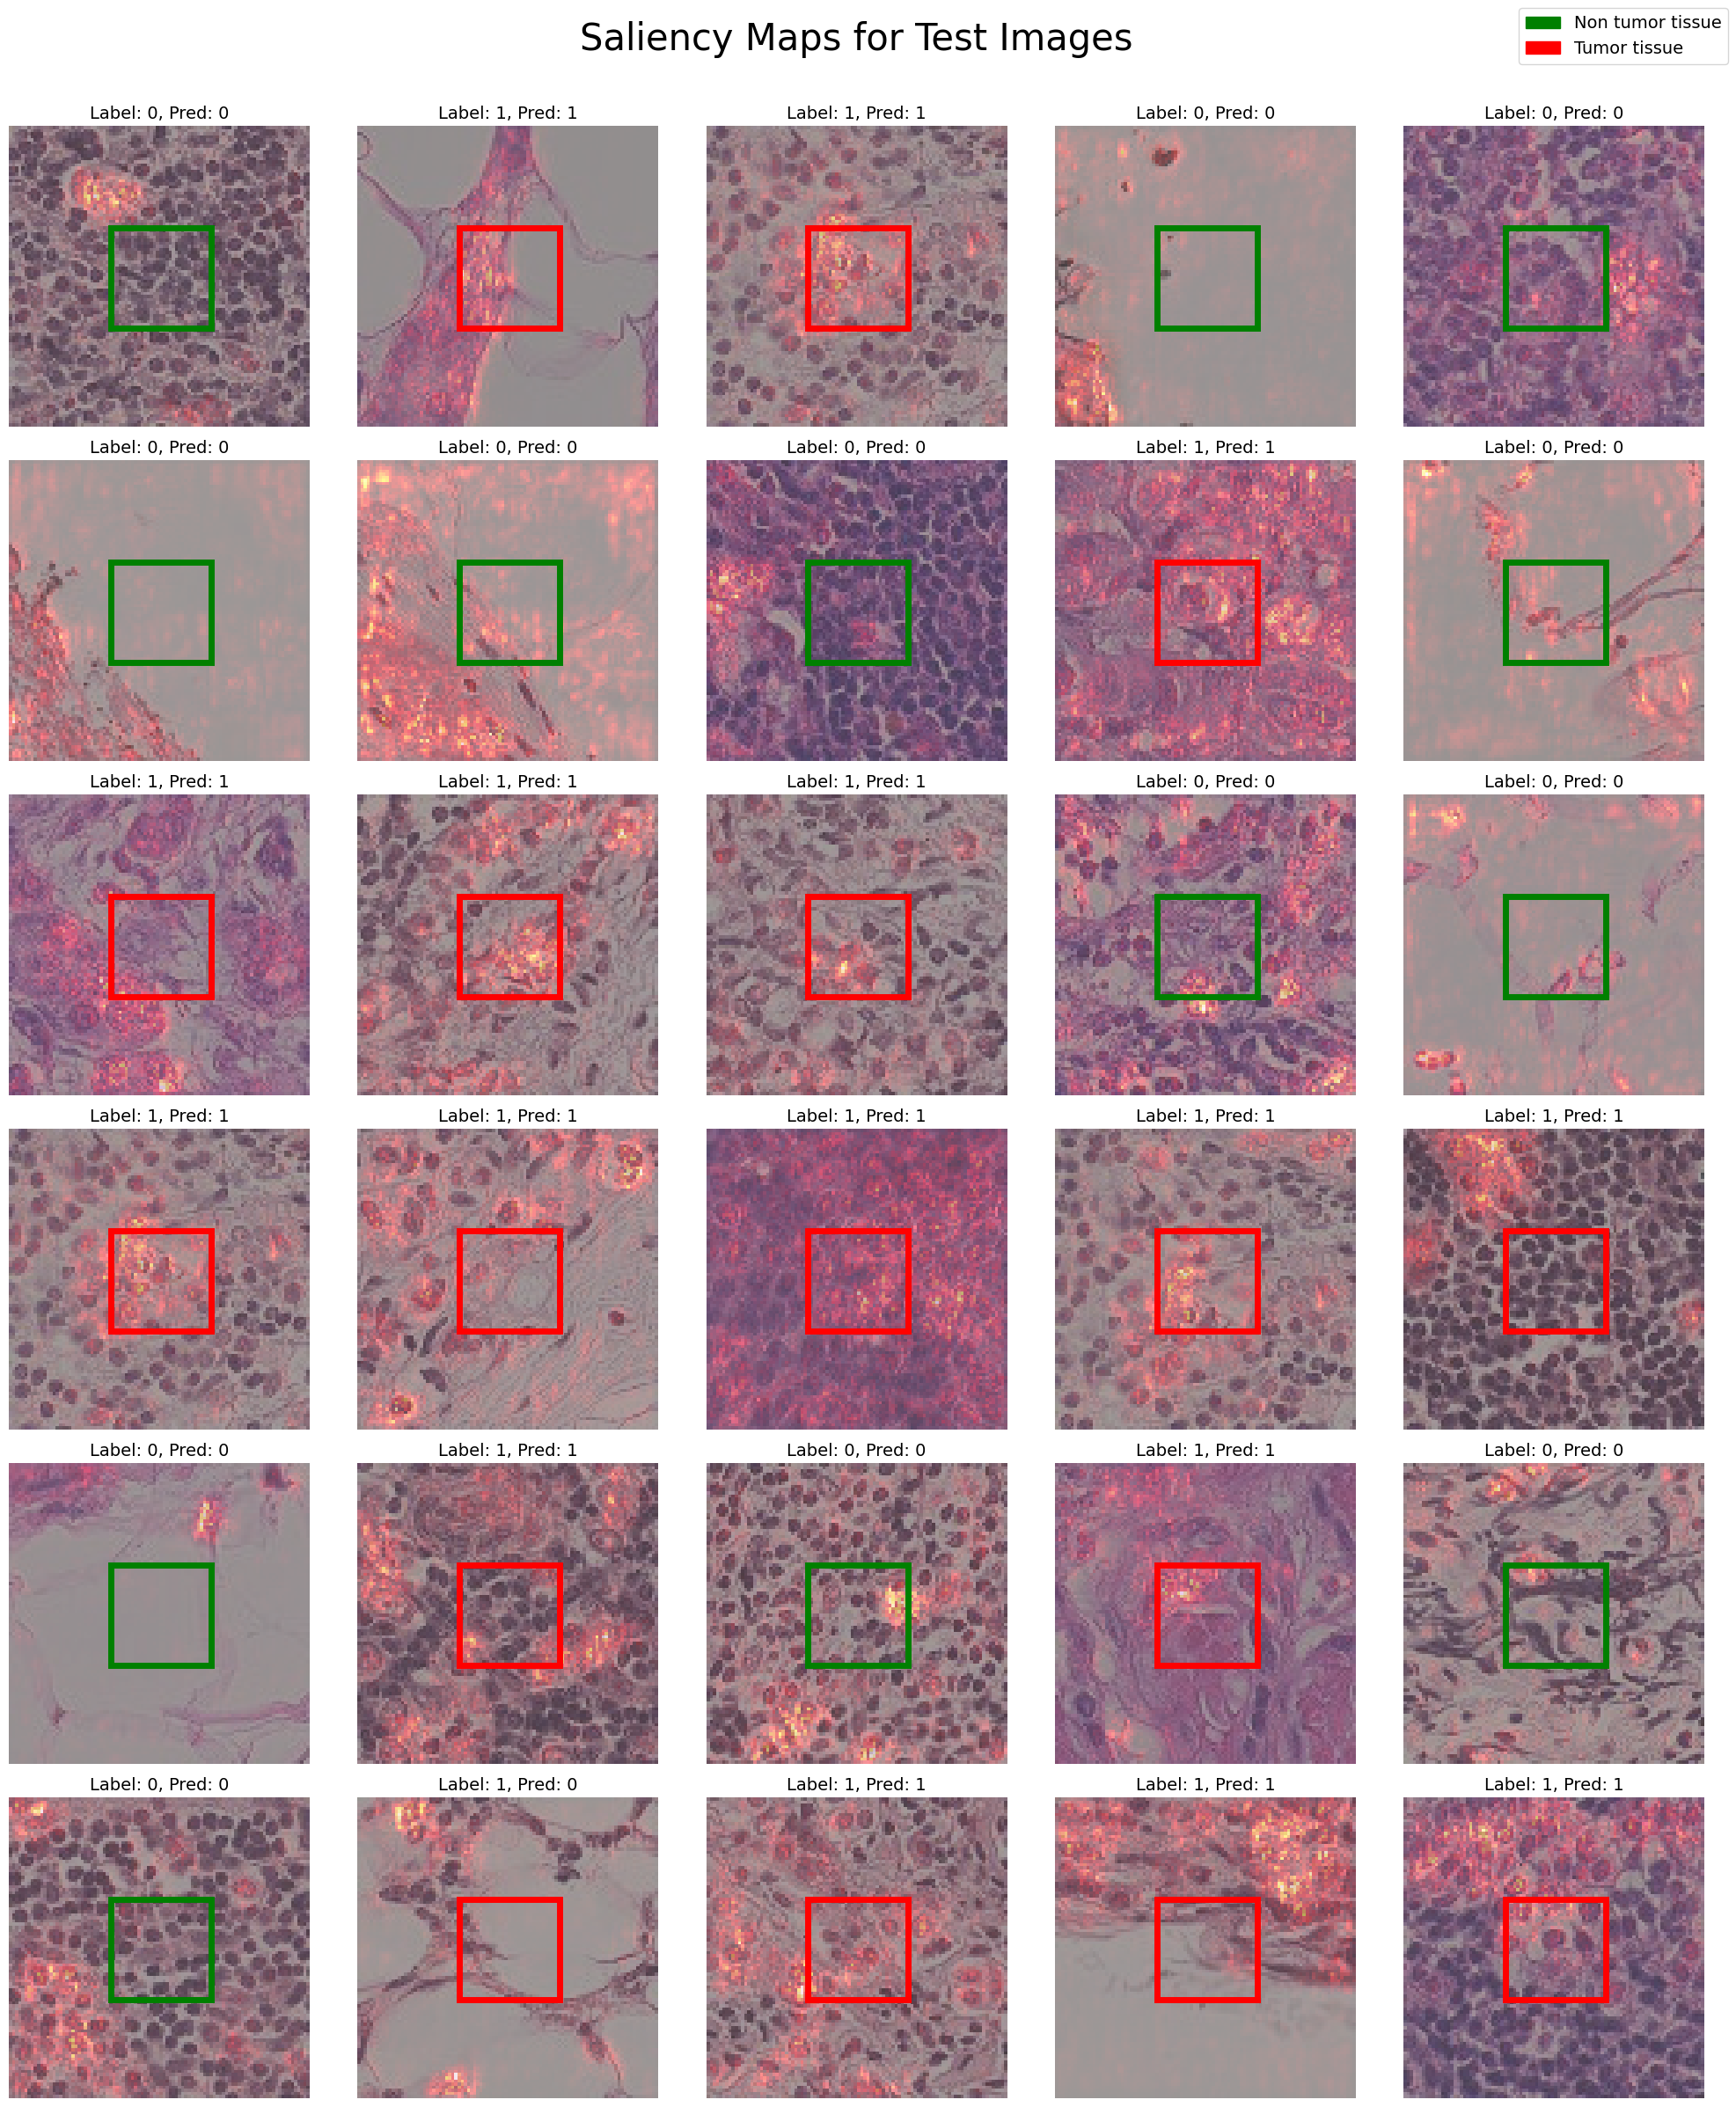

In [102]:
def compute_saliency_maps(model, input_tensor, target_class=None):
    """
    Compute saliency maps for a given input tensor.
    """
    model.eval()
    input_tensor = input_tensor.unsqueeze(0).to(device)
    input_tensor.requires_grad = True

    output = model(input_tensor)
    if target_class is None:
        target_class = output.argmax(dim=1).item()

    model.zero_grad()
    output[0, target_class].backward()

    saliency = input_tensor.grad.abs().squeeze(0).cpu().numpy()
    saliency = saliency.max(axis=0)  # Take the maximum across color channels
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)  # Normalize
    return saliency

# Générer les saliency maps pour les 30 premières images de test
images_to_plot = 30
saliency_maps = []
for i in range(images_to_plot):
    saliency_map = compute_saliency_maps(model, test_images[i])
    saliency_maps.append(saliency_map)

# Visualiser les images originales et leurs saliency maps correspondantes
fig, axes = plt.subplots(6, 5, figsize=(20, 24))

for idx, ax in enumerate(axes.flat):
    if idx >= images_to_plot:
        break
    # Image originale
    img = test_images[idx].cpu().permute(1, 2, 0).numpy()
    ax.imshow(img, alpha=0.6)
    ax.imshow(saliency_maps[idx], cmap='hot', alpha=0.4)
    ax.axis('off')
    # Dessiner un carré rouge si l'étiquette est False, vert sinon
    color = 'green' if test_labels[idx].item() == 0 else 'red'
    rect = patches.Rectangle((32, 32), 32, 32, linewidth=5, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    # Étiquette prédite
    predicted_label = (model(test_images[idx].unsqueeze(0)).item() > 0.5)
    ax.set_title(f"Label: {test_labels[idx].item()}, Pred: {int(predicted_label)}", fontsize=14)

# Ajouter un titre à la figure
fig.suptitle("Saliency Maps for Test Images", fontsize=30, y=0.99)

# Ajouter une légende
legend_patches = [
    patches.Patch(color='green', label='Non tumor tissue'),
    patches.Patch(color='red', label='Tumor tissue')
]
fig.legend(handles=legend_patches, loc='upper right', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.98])  # Ajuster la mise en page pour le titre et la légende
plt.show()

Results are less tangible with saliency maps and highlighted areas dont't always match with the presence of cancerous tissue in the red square zone

## Performance Comparison

To evaluate and compare the performance of Grad-CAM and saliency maps, we use two metrics: insertion and deletion. These metrics help us understand how well each method highlights the most important regions of the image for the model's predictions.

- Insertion: Measures the increase in model confidence as important regions of the image are gradually added back. A higher insertion score indicates that the highlighted regions are crucial for the model's decision-making process.

- Deletion: Measures the decrease in model confidence as important regions of the image are gradually removed. A lower deletion score indicates that the highlighted regions are essential for the model's predictions.

By comparing the insertion and deletion scores for Grad-CAM and saliency maps, we can assess which method provides more accurate and meaningful explanations of the model's behavior.

C:\Users\guill\AppData\Local\Temp\ipykernel_30632\3269150396.py:15: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  gradients = model.feature_map.grad  # devrait être None ici : on va hook


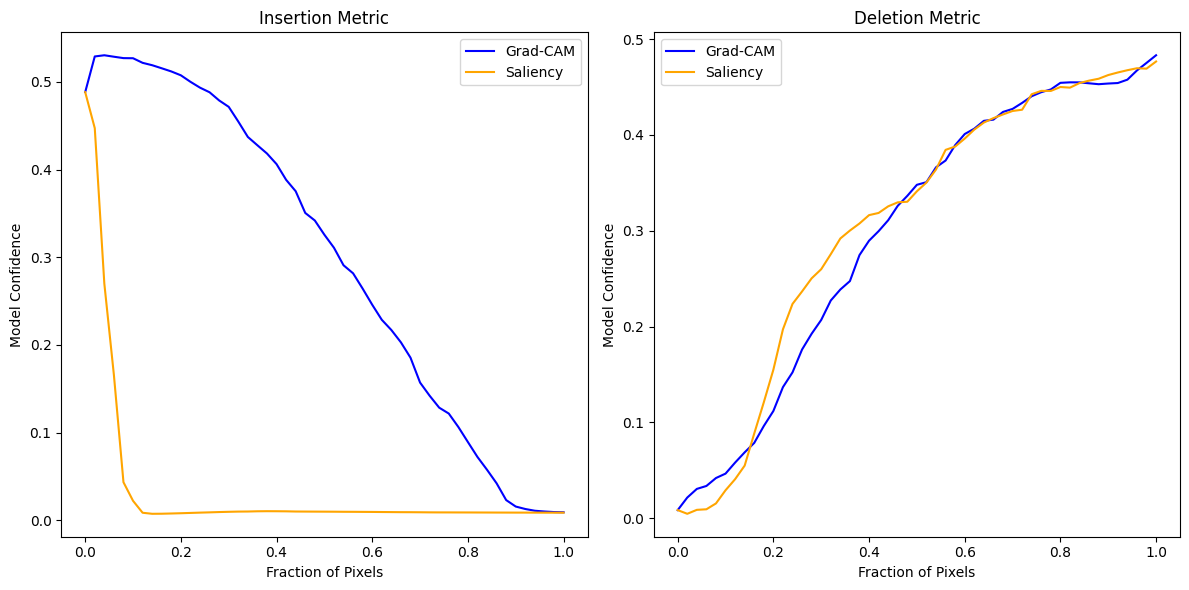

In [108]:
def compute_insertion_deletion(model, input_tensor, heatmap, steps=50):
    """
    Compute insertion and deletion metrics for a given heatmap.
    """
    model.eval()
    input_tensor = input_tensor.unsqueeze(0).to(device)
    heatmap = cv2.resize(heatmap, (input_tensor.shape[2], input_tensor.shape[3]))
    heatmap = torch.tensor(heatmap).unsqueeze(0).unsqueeze(0).to(device)

    # Normalize heatmap
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

    # Generate masks for insertion and deletion
    insertion_scores = []
    deletion_scores = []
    baseline = torch.zeros_like(input_tensor).to(device)

    for step in range(steps + 1):
        mask = (heatmap >= (step / steps)).float()
        insertion_input = input_tensor * mask + baseline * (1 - mask)
        deletion_input = input_tensor * (1 - mask) + baseline * mask

        with torch.no_grad():
            insertion_score = model(insertion_input).item()
            deletion_score = model(deletion_input).item()

        insertion_scores.append(insertion_score)
        deletion_scores.append(deletion_score)

    return insertion_scores, deletion_scores

# Compute metrics for Grad-CAM and Saliency Maps
gradcam_insertion, gradcam_deletion = [], []
saliency_insertion, saliency_deletion = [], []

for i in range(50):
    # Grad-CAM
    gradcam_heatmap = apply_gradcam(model, test_images[i])
    insertion, deletion = compute_insertion_deletion(model, test_images[i], gradcam_heatmap)
    gradcam_insertion.append(insertion)
    gradcam_deletion.append(deletion)

    # Saliency Map
    saliency_map = compute_saliency_maps(model, test_images[i])
    insertion, deletion = compute_insertion_deletion(model, test_images[i], saliency_map)
    saliency_insertion.append(insertion)
    saliency_deletion.append(deletion)

# Plot average insertion and deletion curves
steps = 50
x = [i / steps for i in range(steps + 1)]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x, np.mean(gradcam_insertion, axis=0), label="Grad-CAM", color="blue")
plt.plot(x, np.mean(saliency_insertion, axis=0), label="Saliency", color="orange")
plt.title("Insertion Metric")
plt.xlabel("Fraction of Pixels")
plt.ylabel("Model Confidence")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, np.mean(gradcam_deletion, axis=0), label="Grad-CAM", color="blue")
plt.plot(x, np.mean(saliency_deletion, axis=0), label="Saliency", color="orange")
plt.title("Deletion Metric")
plt.xlabel("Fraction of Pixels")
plt.ylabel("Model Confidence")
plt.legend()

plt.tight_layout()
plt.show()

Grad-CAM (blue curve) shows a higher confidence increase compared to Saliency Maps (orange curve), indicating that Grad-CAM highlights more relevant regions for the model's decision-making process.
The steep rise in the Grad-CAM curve at the beginning suggests that the most important pixels identified by Grad-CAM have a significant impact on the model's confidence.
In contrast, the Saliency curve decreases, suggesting that it may not focus as effectively on the most critical regions.


Saliency Maps (orange curve) show a faster drop in confidence compared to Grad-CAM (blue curve), indicating that the regions identified by Saliency Maps are also important for the model's predictions.
However, the Grad-CAM curve shows a more gradual decline, suggesting that it may distribute importance across a broader set of regions, making it less sensitive to the removal of specific pixels.

Overall, Grad-CAM performs better in the Insertion Metric, highlighting its ability to identify the most critical regions for the model's predictions.
Saliency Maps perform better in the Deletion Metric, indicating that the regions they highlight are also essential for the model's confidence.
The combination of these metrics suggests that Grad-CAM may provide more focused explanations, while Saliency Maps may capture a broader range of important regions.
This analysis highlights the complementary strengths of these two methods and underscores the importance of using multiple metrics to evaluate explainability techniques.

## Other Techniques

### Occulsion Sensitivity

Occlusion Sensitivity is an explainability technique where parts of an image are systematically occluded (e.g., masked with black patches), and the model's confidence is measured for each occlusion. By sliding the occlusion across the image, a heatmap is generated to show which regions are most important for the model's prediction. This helps identify the areas the model relies on for its decisions.



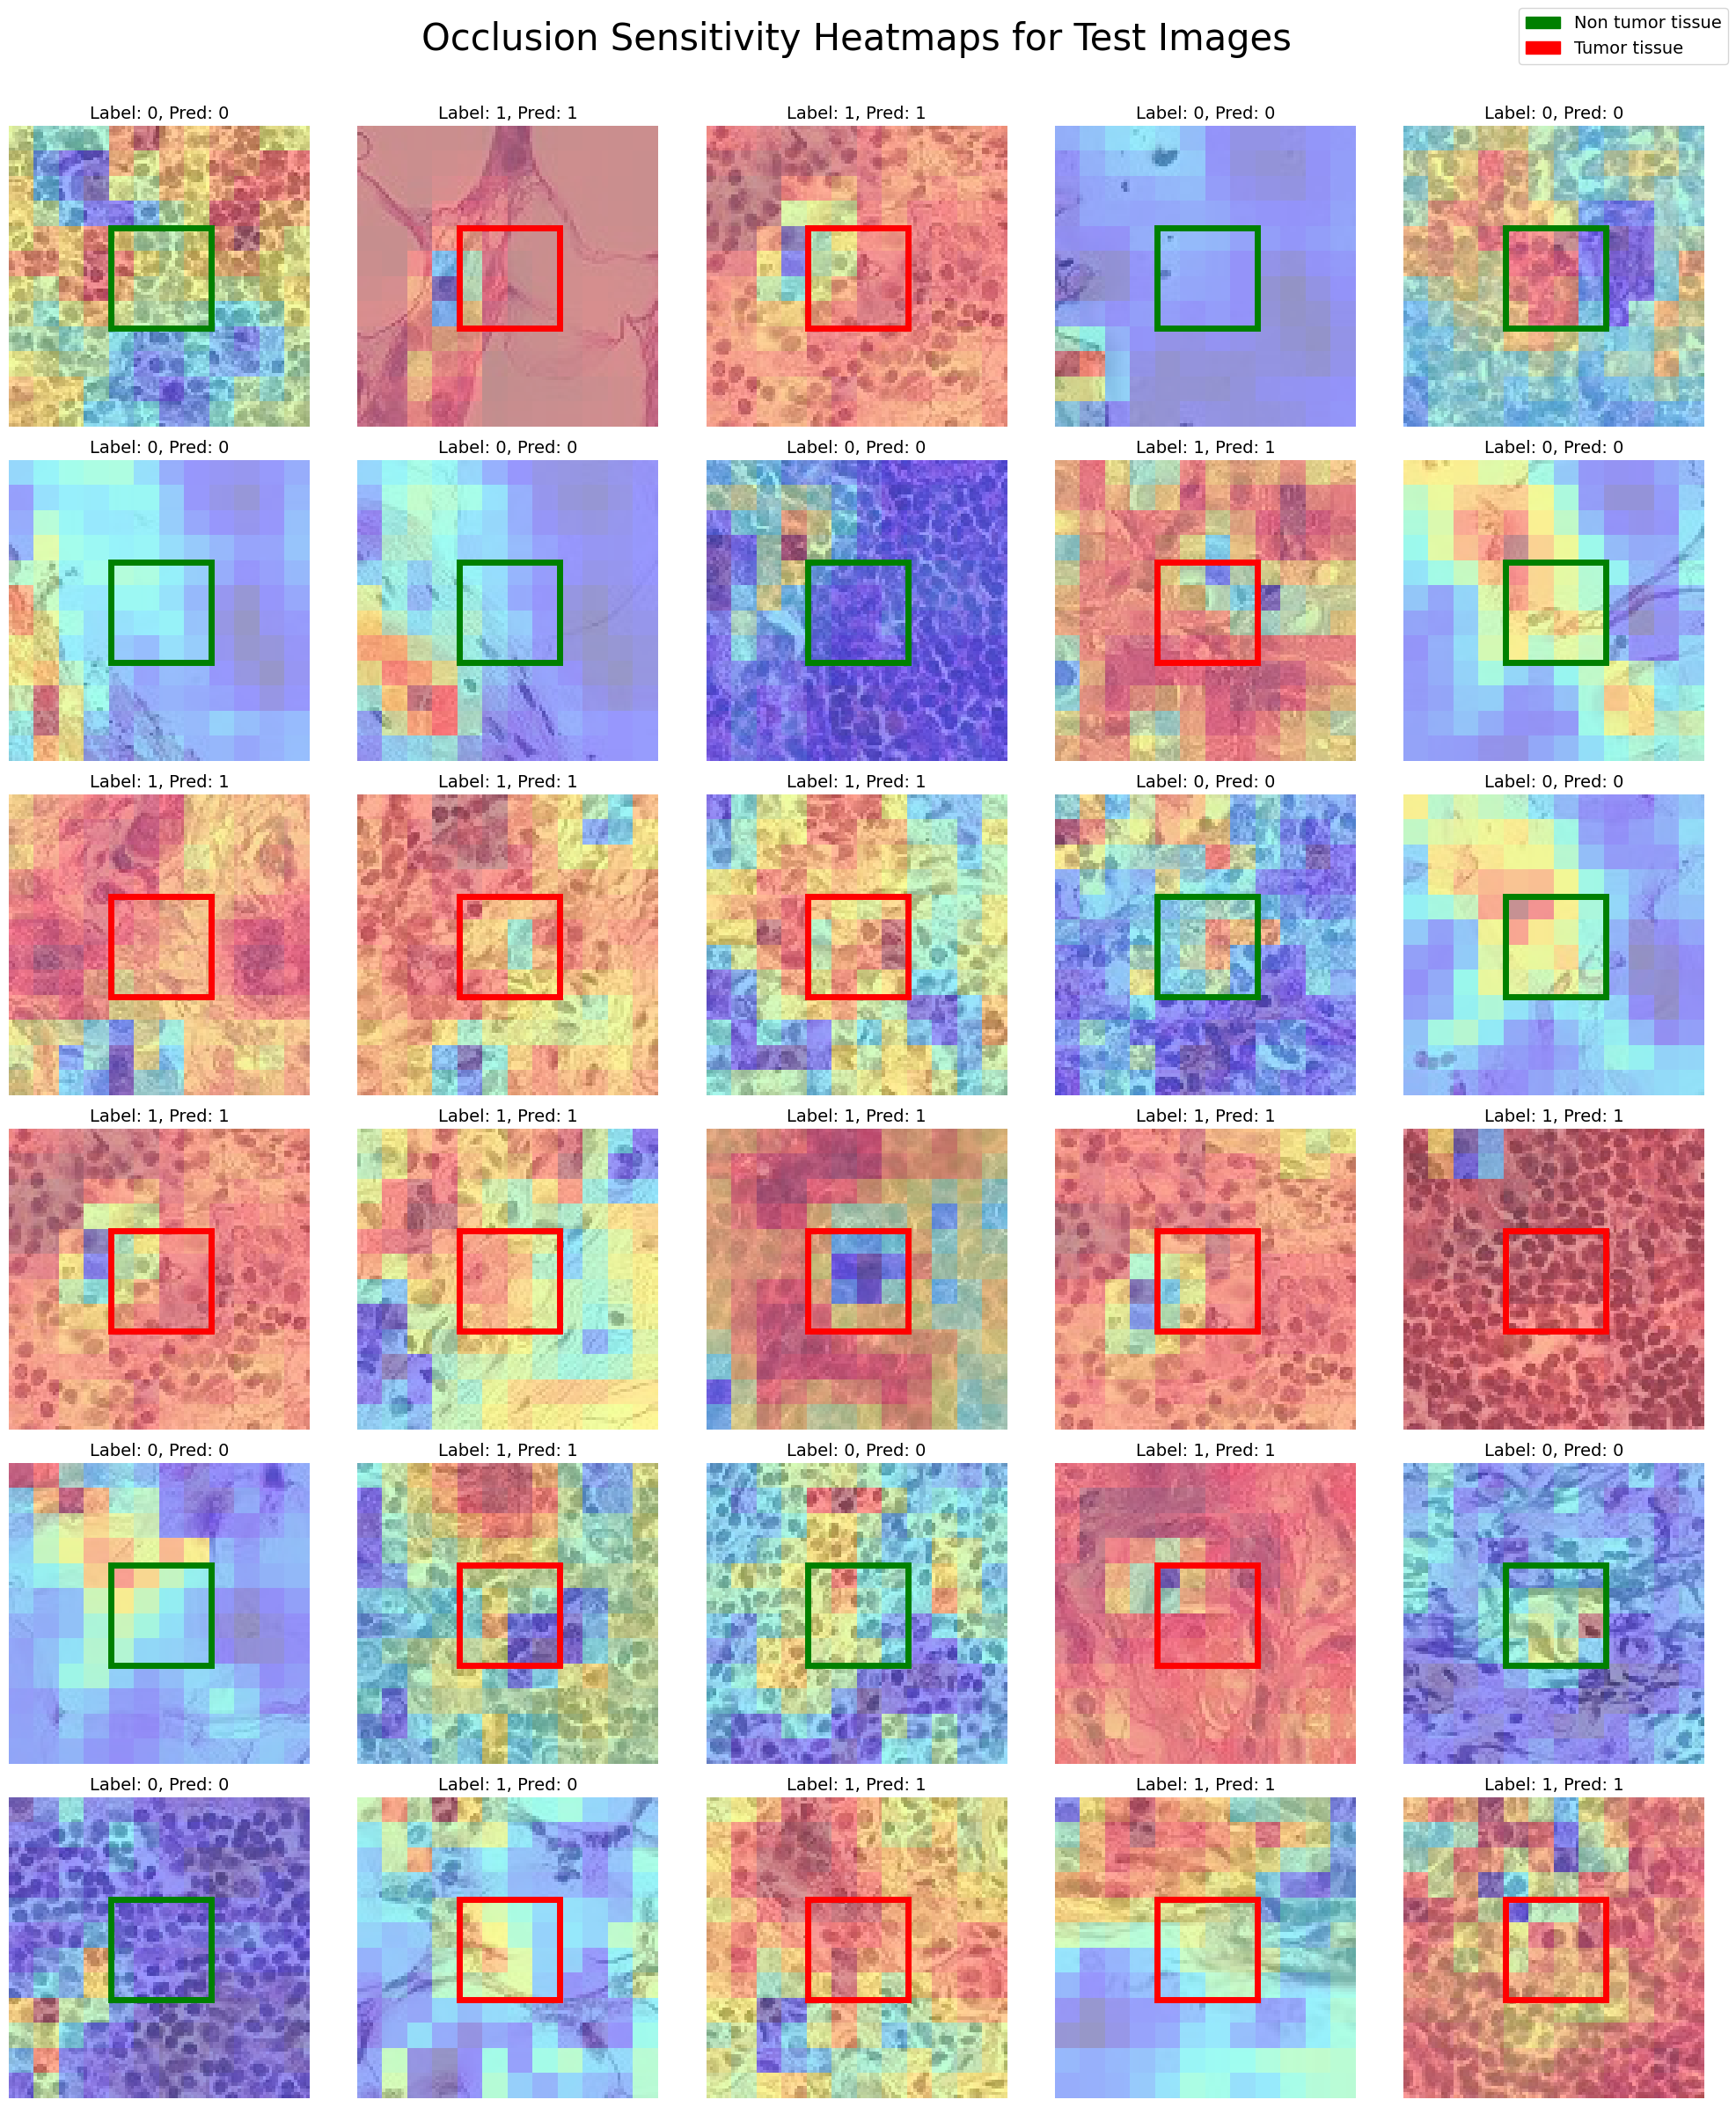

In [100]:
import torch.nn.functional as F

def occlusion_sensitivity(model, input_tensor, label, patch_size=16, stride=8):
    """
    Compute occlusion sensitivity heatmap for a given input image.
    """
    model.eval()
    input_tensor = input_tensor.unsqueeze(0).to(device)
    _, H, W = input_tensor.shape[1:]
    heatmap = torch.zeros((H, W))

    for i in range(0, H, stride):
        for j in range(0, W, stride):
            occluded_input = input_tensor.clone()
            occluded_input[:, :, i:i+patch_size, j:j+patch_size] = 0  # Mask patch
            output = model(occluded_input)
            prob = F.sigmoid(output).item()
            heatmap[i:i+patch_size, j:j+patch_size] = prob

    heatmap = heatmap.cpu().numpy()
    heatmap = cv2.resize(heatmap, (96, 96))
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    return heatmap

# Plot the first 30 test images with their Occlusion Sensitivity heatmaps
images_to_plot = 30
fig, axes = plt.subplots(6, 5, figsize=(20, 24))

for idx, ax in enumerate(axes.flat):
    if idx >= images_to_plot:
        break
    # Original image
    input_image = test_images[idx]
    label = test_labels[idx]
    occlusion_map = occlusion_sensitivity(model, input_image, label)

    img = input_image.cpu().permute(1, 2, 0).numpy()
    ax.imshow(img, alpha=0.6)
    ax.imshow(occlusion_map, cmap='jet', alpha=0.4)
    ax.axis('off')
    # Draw a red square if the label is False, green otherwise
    color = 'green' if label.item() == 0 else 'red'
    rect = patches.Rectangle((32, 32), 32, 32, linewidth=5, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    # Predicted label
    predicted_label = (model(input_image.unsqueeze(0)).item() > 0.5)
    ax.set_title(f"Label: {label.item()}, Pred: {int(predicted_label)}", fontsize=14)

# Add a title to the figure
fig.suptitle("Occlusion Sensitivity Heatmaps for Test Images", fontsize=30, y=0.99)

# Add a legend
legend_patches = [
    patches.Patch(color='green', label='Non tumor tissue'),
    patches.Patch(color='red', label='Tumor tissue')
]
fig.legend(handles=legend_patches, loc='upper right', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to fit title and legend
plt.show()

Red/yellow regions indicate areas where occlusion significantly reduces the model's confidence, meaning these regions are important for the prediction and blue regions indicate areas that have little to no impact on the model's confidence when occluded.

In many cases, the heatmaps for Label1 images correctly highlight regions within the red bounding box, indicating that the model is focusing on the tumor tissue for its predictions. For Label: 0 images, the heatmaps generally avoid the red bounding box and highlight other areas, which aligns with the expected behavior.
However, there are some inconsistencies:
- In a few cases, the heatmaps for Label: 0 images still highlight regions within the red bounding box, which may indicate that the model is overfitting or misinterpreting features.
- Similarly, for some Label: 1 images, the heatmaps do not fully align with the red bounding box, suggesting that the model might not be entirely focused on the tumor tissue.

The results are mostly as expected, with the model focusing on relevant regions for both tumor and non-tumor predictions.
However, the inconsistencies in some heatmaps suggest that the model may still rely on irrelevant features in certain cases. This could be improved by refining the model or using additional regularization techniques to ensure it learns more robust and meaningful features.

### Integrated Gradients

Integrated Gradients is an explainability technique that attributes the importance of each input feature to a model's prediction. It works by Baseline Comparison, Interpolation (gradually interpolating between the baseline and the input) and Gradient Averaging (computing gradients at each interpolation step and averaging them to estimate feature importance)
This method highlights which parts of the input contribute most to the model's decision.

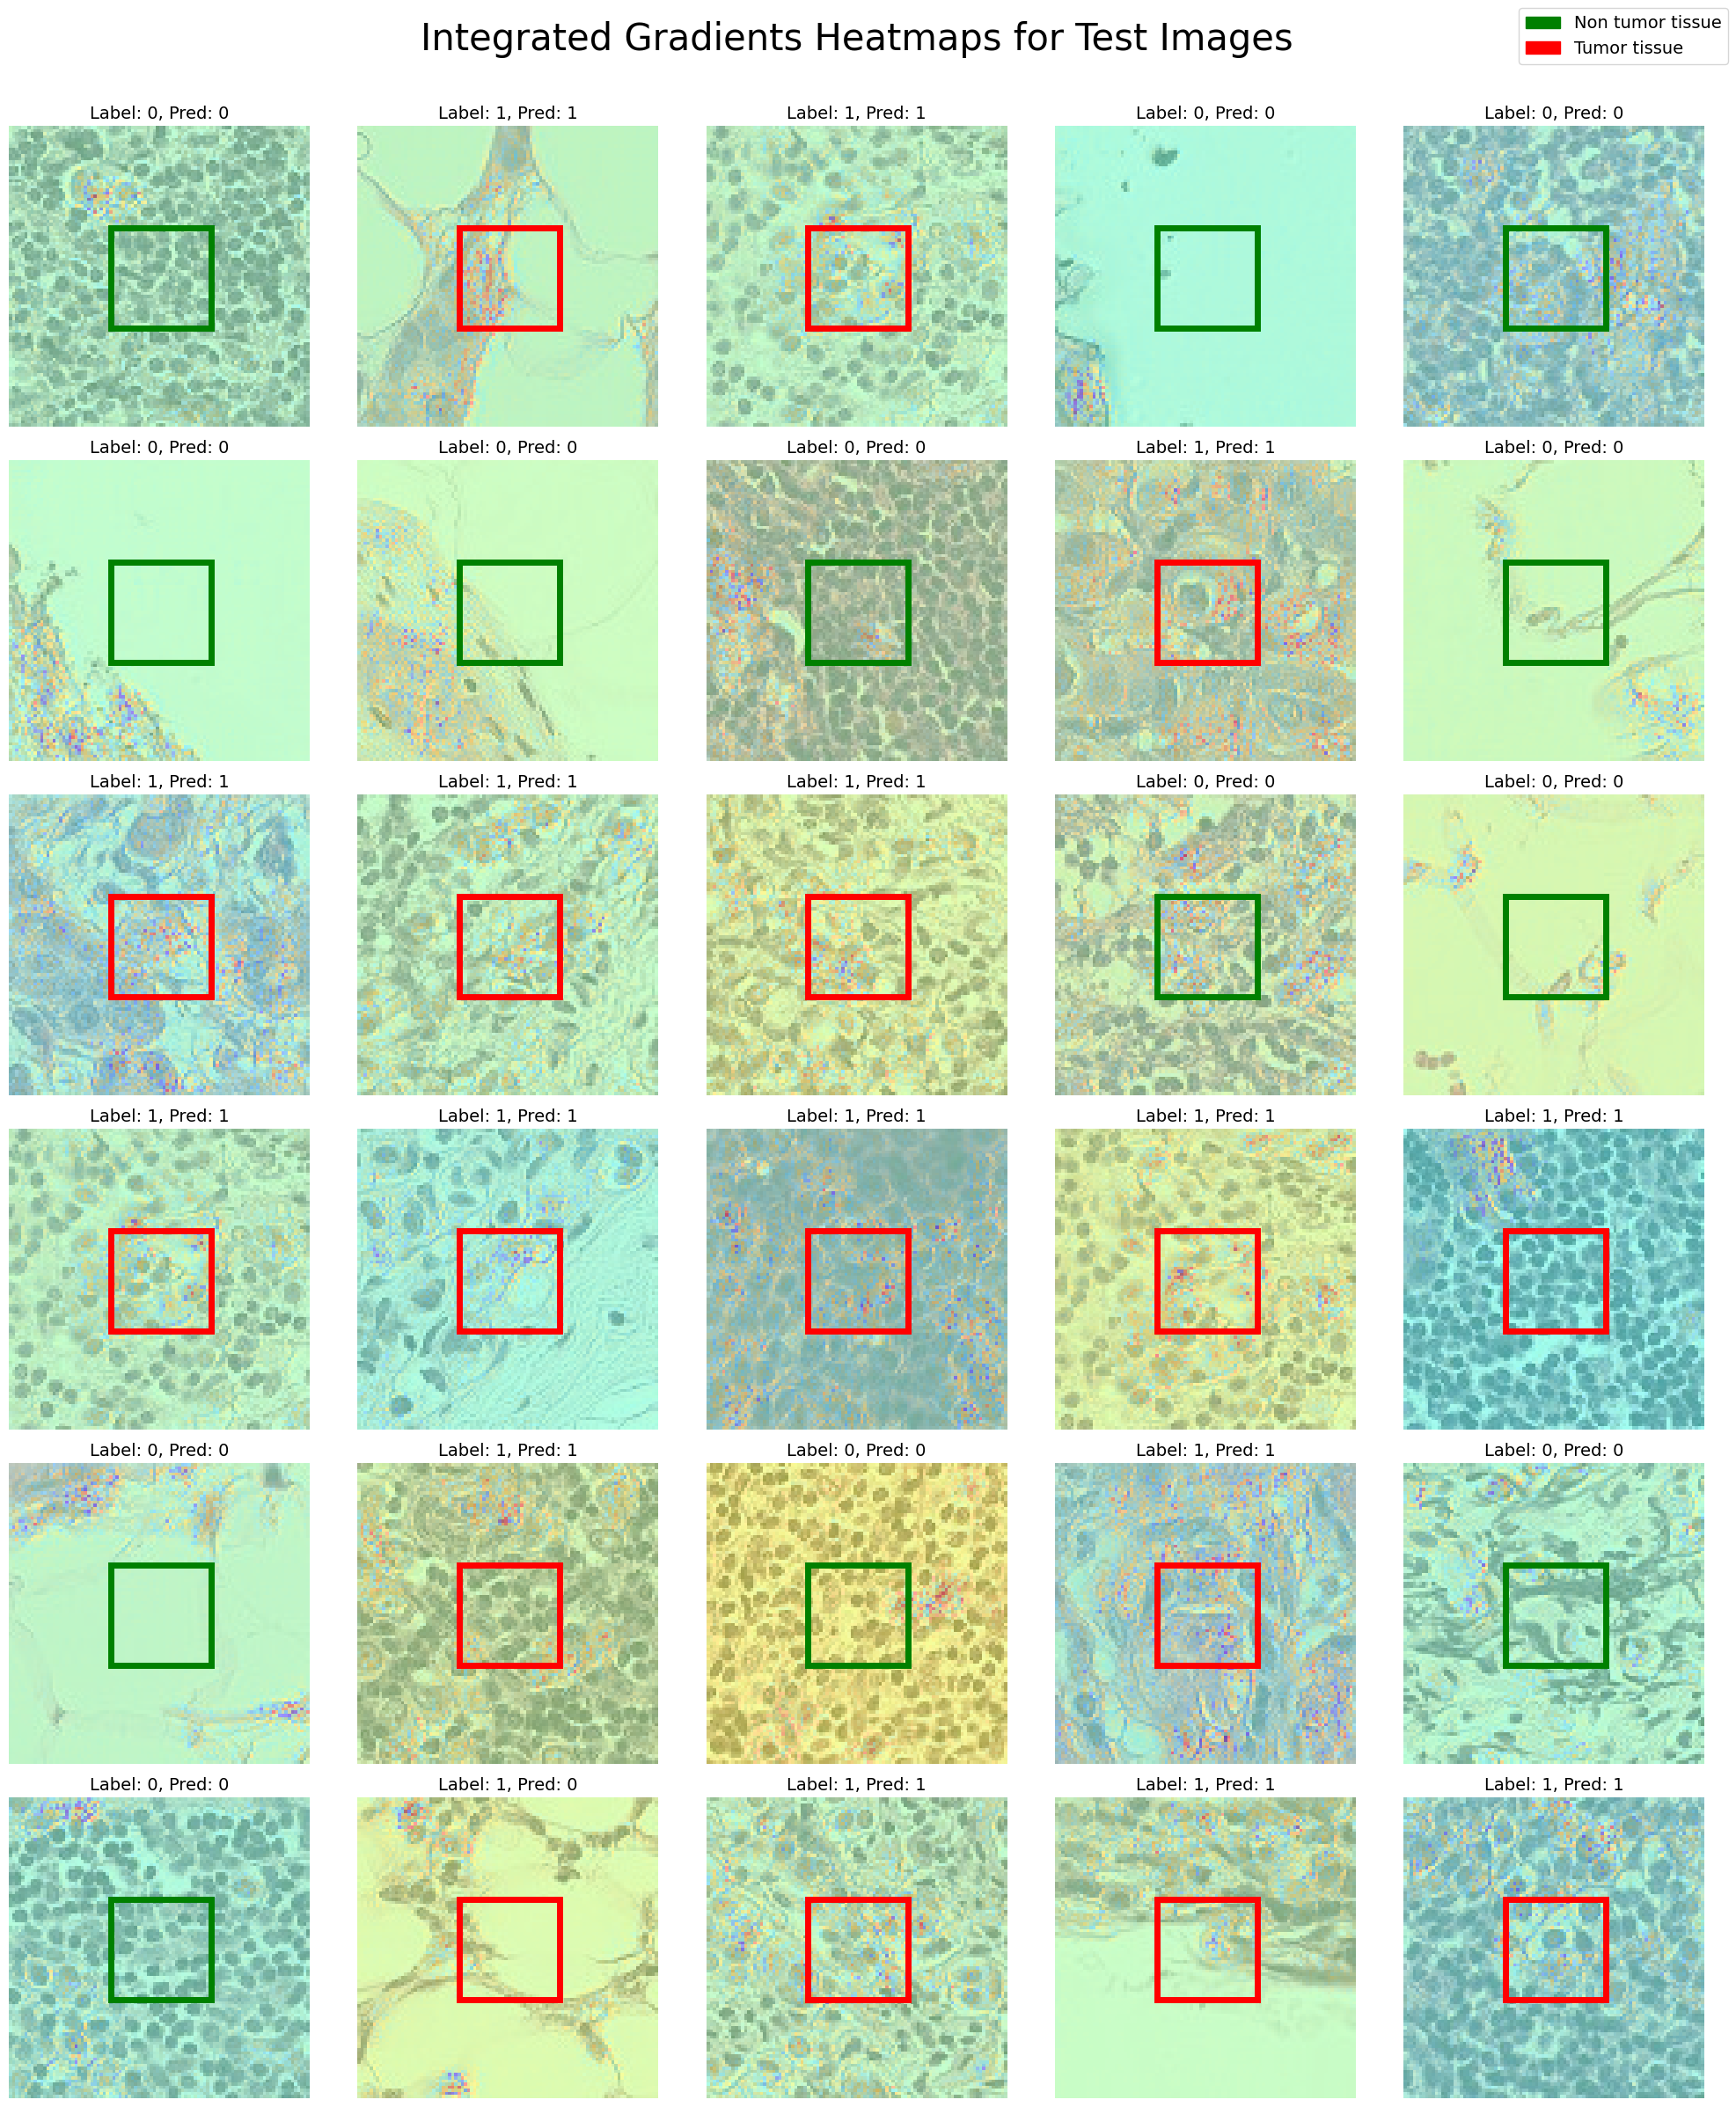

In [97]:
def integrated_gradients(model, input_tensor, baseline=None, steps=50):
    """
    Compute Integrated Gradients for a given input image.
    """
    if baseline is None:
        baseline = torch.zeros_like(input_tensor).to(device)
    input_tensor = input_tensor.unsqueeze(0).to(device)
    baseline = baseline.unsqueeze(0).to(device)

    scaled_inputs = [baseline + (float(i) / steps) * (input_tensor - baseline) for i in range(steps + 1)]
    scaled_inputs = torch.cat(scaled_inputs, dim=0)

    model.eval()
    scaled_inputs.requires_grad = True
    outputs = model(scaled_inputs)
    target = outputs[:, 0].sum()  # Assuming binary classification
    target.backward()

    gradients = scaled_inputs.grad
    avg_gradients = gradients.mean(dim=0)
    integrated_grad = (input_tensor - baseline) * avg_gradients
    return integrated_grad.squeeze(0).cpu().numpy()

# Plot the first 30 test images with their Integrated Gradients heatmaps
images_to_plot = 30
fig, axes = plt.subplots(6, 5, figsize=(20, 24))

for idx, ax in enumerate(axes.flat):
    if idx >= images_to_plot:
        break
    # Original image
    img = test_images[idx].cpu().permute(1, 2, 0).numpy()
    baseline = torch.zeros_like(test_images[idx])  # Black image as baseline
    ig_map = integrated_gradients(model, test_images[idx], baseline)
    ax.imshow(img, alpha=0.6)
    ax.imshow(ig_map.sum(axis=0), cmap='jet', alpha=0.4)
    ax.axis('off')
    # Draw a red square if the label is False, green otherwise
    color = 'green' if test_labels[idx].item() == 0 else 'red'
    rect = patches.Rectangle((32, 32), 32, 32, linewidth=5, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    # Predicted label
    predicted_label = (model(test_images[idx].unsqueeze(0)).item() > 0.5)
    ax.set_title(f"Label: {test_labels[idx].item()}, Pred: {int(predicted_label)}", fontsize=14)

# Add a title to the figure
fig.suptitle("Integrated Gradients Heatmaps for Test Images", fontsize=30, y=0.99)

# Add a legend
legend_patches = [
    patches.Patch(color='green', label='Non tumor tissue'),
    patches.Patch(color='red', label='Tumor tissue')
]
fig.legend(handles=legend_patches, loc='upper right', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to fit title and legend
plt.show()

For Label: 1 images, the heatmaps often emphasize regions within the red bounding box, suggesting that the model is effectively identifying tumor tissue. Conversely, for Label: 0 images, the heatmaps generally avoid the red bounding box, which aligns with the expected behavior.

However, some inconsistencies are observed:
- In certain Label: 0 images, the heatmaps highlight areas within the red bounding box, implying that the model might be focusing on irrelevant features.
- For some Label: 1 images, the highlighted regions do not fully correspond to the red bounding box, indicating that the model may not always concentrate on the tumor tissue.

Conclusion:

Overall, the model demonstrates a tendency to focus on relevant regions for both tumor and non-tumor predictions. Nevertheless, the observed inconsistencies suggest that the model occasionally relies on less meaningful features. Addressing this issue could involve refining the model further or incorporating additional regularization techniques to enhance its robustness.
